In [1]:
# imports
from typing import Tuple, List
import time
from os import path
import requests

import urllib
import zipfile
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Exercice 1 : 

In [2]:
url = u'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/'
filename = 'household_power_consumption'
zipfilename = filename + '.zip'
location = url + zipfilename
if not path.isfile(zipfilename):
    urllib.request.urlretrieve(location, zipfilename)
zipfile.ZipFile(zipfilename).extractall()
na_values = ['?', '']
fields = ['Date', 'Time', 'Global_active_power']
df = pd.read_csv(filename + '.txt', sep=';', nrows=200000,
                 na_values=na_values, usecols=fields)

## Question 1 : 

In [3]:
# count missing values
df.isnull().sum()

Date                      0
Time                      0
Global_active_power    3732
dtype: int64

In [4]:
# delete rows with missing values
df = df.dropna()

In [5]:
# sanity check
df.isnull().sum()

Date                   0
Time                   0
Global_active_power    0
dtype: int64

# Question 2 :

In [6]:
df['DateTime'] = df['Date'] +' '+ df['Time']

In [7]:
# datetime to timetime 
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [8]:
# set index to DateTime
df = df.set_index('DateTime')


In [9]:
# Time and Date are now useless 
df.drop(['Date', 'Time'], axis=1, inplace=True)


In [10]:
df.head()

,Global_active_power
DateTime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


# question 3 : 

<AxesSubplot:xlabel='DateTime'>

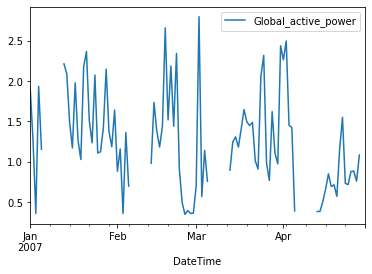

In [11]:
# average power consumption per day 
df_daily = df.resample('D').mean()

# plot global_active_power between january 1 2007 and april 30 2007 
df_daily.loc['2007-01-01':'2007-04-30'].plot(y='Global_active_power')



## Question 4 :

In [12]:

# load https://perso.telecom-paristech.fr/sabourin/mdi720/TG_STAID011249.txt
url = 'https://perso.telecom-paristech.fr/sabourin/mdi720/TG_STAID011249.txt'
response = requests.get(url)
temp_txt = response.text

# some custom code to clean text file could be done manually ... 
temp_txt = temp_txt.split('#See files sources.txt and stations.txt for more info.')[-1].split('#')[-1]
temp_txt = temp_txt.split('\n')
temp_txt = [line.replace('\r','').strip() for line in temp_txt][1:-1]
temp_header = [col.strip() for col in temp_txt[0].split(',')]
def clean_line(line):
    line = line.split(',')
    line = [col.strip() for col in line]
    # to numeric 
    line = [float(col) for col in line]
    # date
    line[2] = str(int(line[2]))
    return line
temp_list = [clean_line(row) for row in temp_txt[1:]]

df_temp = pd.DataFrame(temp_list, columns=temp_header)
df_temp = df_temp[['DATE', 'TG']]
df_temp.head()

,DATE,TG
0,19210301,50.0
1,19210302,46.0
2,19210303,46.0
3,19210304,31.0
4,19210305,95.0


In [13]:
# temp to celcius 
df_temp['TG'] = df_temp['TG']/10

In [14]:
# check missing values
df_temp.isnull().sum()

DATE    0
TG      0
dtype: int64

In [15]:
# timestamp to datetime
df_temp['DATE'] = pd.to_datetime(df_temp['DATE'])

In [16]:
# reset index
df_temp = df_temp.set_index('DATE')


In [17]:
df_temp

,TG
DATE,
1921-03-01,5.0
1921-03-02,4.6
1921-03-03,4.6
1921-03-04,3.1
1921-03-05,9.5
...,...
2016-08-27,26.6
2016-08-28,25.5
2016-08-29,20.6


## Question 5 :

In [18]:
# merge with df_daily
df_daily = df_daily.join(df_temp, how='inner')
df_daily.head()

,Global_active_power,TG
2006-12-16,3.053475,6.0
2006-12-17,2.354486,2.8
2006-12-18,1.530435,3.5
2006-12-19,1.157079,2.4
2006-12-20,1.545658,3.0


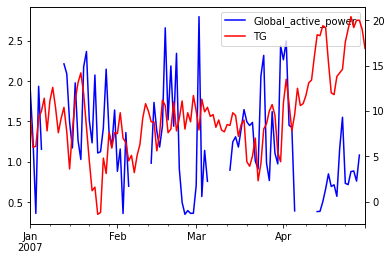

In [19]:

# plot temperature and Global_active_power  between january 1 2007 and april 30 2007 
df_filter = df_daily.loc['2007-01-01':'2007-04-30']

fig, ax = plt.subplots()

df_filter['Global_active_power'].plot(ax=ax, style='b-',label='Global_active_power')
df_filter['TG'].plot(ax=ax, style='r-', secondary_y=True, label ='temperature')

ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]], ['Global_active_power','TG'], loc=0)



- we can see a negative correlation between the temperature  and consuption 
which is expected since we use electricity for heating (a high energy demanding appliance) 

# Exercice 2

### question 6

In [20]:

def get_left_right_sides(n: int, p: int, lbd: float) -> Tuple[np.ndarray, float, np.ndarray, float]:
    # matrices
    X = np.random.normal(
        loc=0, 
        scale=5**2,
        size=(n, p)
    )

    y = np.random.uniform(
        low=-1, 
        high=1, 
        size=(n, 1)
    )

    id_n = np.eye(n)
    id_p = np.eye(p)

    # operations and inv
    # left
    start_time = time.time()

    transpose_with_id_n = X @ X.T + lbd * id_n
    transpose_id_n_times_y = np.linalg.solve(transpose_with_id_n, y)
    left_side = X.T @ transpose_id_n_times_y

    left_duration = time.time() - start_time

    # right
    start_time = time.time()

    transpose_with_id_p = X.T @ X + lbd * id_p
    transpose_id_p_times_xy = np.linalg.solve(transpose_with_id_p, X.T @ y)  
    right_side = transpose_id_p_times_xy

    right_duration = time.time() - start_time

    return left_side, left_duration, right_side, right_duration

In [21]:
# 6. a)

# params
n, p = 100, 2000
lbd = 1e-5

l_side, _, r_side, _ = get_left_right_sides(n, p, lbd)

# check equality
all(np.isclose(l_side, r_side, atol=1e-7))

True

In [22]:
# 6. b)

# params
n, p = 2000, 100
lbd = 1e-5

l_side, _, r_side, _ = get_left_right_sides(n, p, lbd)

# check equality
all(np.isclose(l_side, r_side, atol=1e-6))

True

- for this case, the equality holds for an absolute tolerence greater than $10^{-6}$

### Question 7

In [23]:
# 
def get_duration(n, p):
    _, duration_left, _, duration_right = get_left_right_sides(n, p, lbd)

    return (duration_left, duration_right)


# samples of cases
case_a = [(i, i * 20) for i in range(100, 200+1, 10)]
case_b = [(i * 20, i) for i in range(100, 200+1, 10)]

  
times_case_a = list(
    map(
        lambda tup: get_duration(*tup), 
        case_a
    )
)

times_case_b = list(
    map(
        lambda tup: get_duration(*tup), 
        case_b
    )      
)

In [24]:
# plot

# init figure
fig = make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=["duration for case n << p", "duration for case n >> p"]
)

color_name = {
    0: {
        "name": "left method",
        "color": '#636EFA'
    },
    1: {
        "name": "right method",
        "color": '#EF553B'
    }
}

fig.add_traces(data=[
    go.Bar(
        x=[str(el) for el in case_a],
        y=[tuple_duration[comp_method] for tuple_duration in times_case_a],
        marker_color=color_name[comp_method]["color"],
        name=color_name[comp_method]["name"],
    )
for comp_method in [0, 1]], 
rows=1, cols=1
)

fig.add_traces(data=[
    go.Bar(
        x=[str(el) for el in case_b],
        y=[tuple_duration[comp_method] for tuple_duration in times_case_b],
        marker_color=color_name[comp_method]["color"],
        name=color_name[comp_method]["name"],
        showlegend=False
    )
for comp_method in [0, 1]], 
rows=1, cols=2
)

# set layout
for i in [1, 2]:
    fig.update_yaxes(
        title_text="time", 
        type="log", 
        row=1, col=i
    )


fig.show()

- It is time efficient to use the left method in the case $n << p$. On the other hand, it turns out that
the right method is the one to opt for in case $n >> p$

- In addition, if we analyse the time complexity of the two operation (without taking on account inv operation)
    - left method: $O(n^2 \ p)$
    - right method: $O(p^2 \ n)$

which shows clearly cases where to choose the method to work with

# Exercice 3

### question 8

In [25]:
# choosen distributions
DICT_DIST = {
        "uniform": {
            "func": np.random.uniform,
            "mean": 1/2,
            "sigma": np.sqrt(1/12),
            "color": '#636EFA'
        },
        "exponential": {
            "func": np.random.exponential,
            "mean": 1.,
            "sigma": 1.,
            "color": '#EF553B'
        },
        "poisson": {
            "func": np.random.poisson,
            "mean": 1.,
            "sigma": 1.,
            "color": '#00CC96'
        },
    }

TARGET_MEAN = 0
TARGET_VARIANCE = 2


def sample_from(n: int, p: int, dist_name: str) -> np.ndarray:
    # select dist
    dist = DICT_DIST[dist_name]
    # sample from it
    samples_dist = dist["func"](size=(n, p))

    # map it to (mean = 0, var=2)
    return np.sqrt(TARGET_VARIANCE) * ((samples_dist - dist["mean"]) / dist["sigma"] + TARGET_MEAN)

In [26]:
# numerical check of mean and variance
interval_n = [10 ** i for i in range(1, 6+1)]

diffirence_to_mean = {
    dist_name: [abs(sample_from(n, 1, dist_name).mean() - TARGET_MEAN) for n in interval_n]
    for dist_name in DICT_DIST
}

diffirence_to_variance = {
    dist_name: [abs(sample_from(n, 1, dist_name).var() - TARGET_VARIANCE) for n in interval_n]
    for dist_name in DICT_DIST
}


In [27]:
# make plot to compare emperical and theorical mean/variance

# init figure
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[f"abs difference to target mean={TARGET_MEAN}", f"abs difference to target variance={TARGET_VARIANCE}"]
)

# plots to compare mean
fig.add_traces(data=[
    go.Scatter(
        x=interval_n,
        y=diffirence_to_mean[dist_name],
        mode="markers+lines",
        name=dist_name,
        marker_color=DICT_DIST[dist_name]["color"]
    )
for dist_name in DICT_DIST],
rows=1, cols=1)

# plots to compare variance
fig.add_traces(data=[
    go.Scatter(
        x=interval_n,
        y=diffirence_to_variance[dist_name],
        mode="markers+lines",
        name=dist_name,
        marker_color=DICT_DIST[dist_name]["color"],
        showlegend=False
    )
for dist_name in DICT_DIST],
rows=1, cols=2)

# set axis layout
for i in [1, 2]:
    fig.update_xaxes(
        title_text="n (samples)", 
        type="log", 
        row=1, col=i
    )
    
fig.show()

- We notice that the more we increase the number of samples, the more we get close to the theorical mean and variance
- This remark is due to the law of large numbers

### question 9

In [28]:

# init figure
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=list(DICT_DIST.keys())
)

# params
n = 1000
values_p = [200, 500, 1000, 2000]
arr_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']

for i, dist_name in enumerate(DICT_DIST):
    for p, color_name in zip(values_p, arr_colors):
        # build and apply svd
        X = sample_from(n, p, dist_name)
        _, singular_vals, _ = np.linalg.svd(X)

        # plot
        fig.add_trace(
            go.Scatter(
                y=singular_vals,
                mode="markers+lines",
                name=f"p={p}",
                marker_color=color_name,
                showlegend=False if dist_name != "uniform" else True
            ),
            row=1, col=i+1
        )

# set axis layout
for i in [1, 2, 3]:
    fig.update_xaxes(
        title_text="singular values",
        row=1, col=i
    )


fig.show()

- We notice that number of singular values is equal to $min(n, p)$. Indeed, the number of singular values is at most
equal to the matrix rank
- We observe that singular values have the same shape for all distributions (when we zoom in, we see that they are slightly different)
- The latter remark can be justified by the fact that all distribution have $mean=0$ and $variance=2$

### question 10

In [29]:

# init figure
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=list(DICT_DIST.keys())
)

# params
n = 1000
values_p = [200, 500, 1000, 2000]
arr_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']

for i, dist_name in enumerate(DICT_DIST):
    for p, color_name in zip(values_p, arr_colors):
        # build and apply svd
        X = sample_from(n, p, dist_name)
        eigen_values, _ = np.linalg.eig(X.T @ X / n)

        # plot
        fig.add_trace(
            go.Scatter(
                y=np.real(eigen_values),
                mode="markers+lines",
                name=f"p={p}",
                marker_color=color_name,
                showlegend=False if dist_name != "uniform" else True
            ),
            row=1, col=i+1
        )

# set axis layout
for i in [1, 2, 3]:
    fig.update_xaxes(
        title_text="eigen values",
        row=1, col=i
    )


fig.show()

- Like the previous question, we observe that at the moment $p$ becomes greater than $n=1000$, all eigen values
becomes zeros.

# Exercice 4

### question 11

In [30]:
# initial implementation
def power_method(X: np.ndarray, max_iterations: int) -> Tuple[np.ndarray, np.ndarray]:
    # X shape
    _, p = X.shape

    # random init of v
    v_k = np.random.rand(p, 1)

    for i in range(max_iterations):
        # update u
        X_times_v = X @ v_k
        u_k = X_times_v / np.linalg.norm(X_times_v)

        # update v
        XT_times_u = X.T @ u_k
        v_k = XT_times_u / np.linalg.norm(XT_times_u)

    return u_k, v_k

In [31]:
# algo modified
def power_method_modified(X: np.ndarray, max_iterations: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    # X shape
    _, p = X.shape

    # random init of v
    arr_v = [np.random.rand(p, 1)]
    arr_u = []

    for i in range(max_iterations):
        # update u
        X_times_v = (X @ arr_v[-1])
        arr_u.append(X_times_v / np.linalg.norm(X_times_v))

        # update v
        XT_times_u = X.T @ (arr_u[-1])
        arr_v.append(XT_times_u / np.linalg.norm(XT_times_u))

    return arr_u, arr_v

In [53]:
# params
n, p = 5, 10
dist_name = "uniform"

# create matrix
X = sample_from(n, p, dist_name)
U, _, V = np.linalg.svd(X)

# leading singular vectors
u_star = U[:, 0][:, None]
v_star = V.T[:, 0][:, None]

In [55]:
# plot of u* - u (resp v* - v)

# params
nb_iteration = 200

arr_u, arr_v = power_method_modified(X, max_iterations=nb_iteration)
rg_1000 = list(range(1, nb_iteration + 1))

# init figure
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["||u* - u||", "||v* - v||"]
)

fig.add_trace(
    go.Scatter(
        x=rg_1000,
        y=[np.linalg.norm(u_star - u) for u in arr_u],
        mode="lines+markers",
        marker_color="#636EFA",
        showlegend=False
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=rg_1000,
        y=[np.linalg.norm(v_star - v) for v in arr_v],
        mode="lines+markers",
        marker_color="#636EFA",
        showlegend=False
    ),
    row=1, col=2
)

# set axis layout
for i in [1, 2]:
    fig.update_xaxes(
        title_text="iteration",
        row=1, col=i
    )

    fig.update_yaxes(
        type="log",
        row=1, col=i
    )

fig.show()

- we can see clearly that as we increase the number of iteration, the distance between $u^*$ and $u$ (resp $v^*$ and $v$)
converge to $0$

### question 14

In [34]:
# modifed version to approx the max singular value
def power_method_singular_value(X: np.ndarray, max_iterations: int) -> float:
    # X shape
    _, p = X.shape

    # random init of v
    v_k = np.random.rand(p, 1)

    for i in range(max_iterations):
        # update u
        X_times_v = X @ v_k
        u_k = X_times_v / np.linalg.norm(X_times_v)

        # update v
        XT_times_u = X.T @ u_k
        v_k = XT_times_u / np.linalg.norm(XT_times_u)

    return np.sqrt(np.linalg.norm((X.T @ X) @ v_k))

In [35]:
# params
n, p = 5, 10
dist_name = "uniform"

# create matrix
X = sample_from(n, p, dist_name)
U, sig, V = np.linalg.svd(X)

# singular value using power method
sv = power_method_singular_value(X, max_iterations=1000)


print(np.isclose(sv, sig[0]))

True


### question 15

In [36]:
def gen_power_method(
    X: np.ndarray, 
    ith_singular: int, 
    max_iterations: int, 
    v: np.ndarray = None, u: np.ndarray = None
    ) -> Tuple[np.ndarray, np.ndarray, float]:
    
    # condition to break recussion
    if ith_singular == 0:
        sig = np.sqrt(np.linalg.norm((X.T @ X) @ v))
        return v, u, sig
    
    # params
    if (u is not None and
        v is not None):
        sig = np.sqrt(np.linalg.norm((X.T @ X) @ v))
        X = X - sig * u @ v.T

    _, p = X.shape

    # random init of v
    v_k = np.random.rand(p, 1)

    for i in range(max_iterations):
        # update u
        X_times_v = X @ v_k
        u_k = X_times_v / np.linalg.norm(X_times_v)

        # update v
        XT_times_u = X.T @ u_k
        v_k = XT_times_u / np.linalg.norm(XT_times_u)

    # get next sv
    return gen_power_method(X, ith_singular-1, max_iterations, v_k, u_k)

In [37]:
# params
n, p = 5, 10
dist_name = "uniform"

# create matrix
X = sample_from(n, p, dist_name)
U, sig, V = np.linalg.svd(X)

# 2nd sv using power method
v, u, sv = gen_power_method(X, ith_singular=2, max_iterations=1000)


np.isclose(sv, sig[1])

True

- The developped function is able to approximate not only the second largest singular value
but also the third, fourth, ... ith singular value

# Exercice 5

### qeustion 16

In [38]:

# load https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original dataframe 
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
header = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
df_auto = pd.read_csv(url, sep='\s+', na_values='?', header=None, names=header)
df_auto


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


In [39]:
# check missing values
df_auto.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [40]:
# drop missing values 
df_auto.dropna(inplace=True)

## Question 17 : 

In [41]:

# add three binary columns : is_US, is_Europe, is_Japan , we will do it in a more ML-ish  way later ...
df_auto['is_US'] = df_auto['origin'] == 1
df_auto['is_Europe'] = df_auto['origin'] == 2
df_auto['is_Japan'] = df_auto['origin'] == 3
df_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,is_US,is_Europe,is_Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,True,False,False
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,True,False,False
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,True,False,False
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,True,False,False
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,True,False,False


 ## question 18 : 

In [42]:
# sample 3 rows from each origin class / we resampled till we found diferent model years ! 
frame_1 = df_auto[df_auto['is_US'] ==True].sample(3)  
frame_2 = df_auto[df_auto['is_Japan'] ==True].sample(3) 
frame_3 =  df_auto[df_auto['is_Europe'] ==True].sample(3)
frames = [frame_1, frame_2, frame_3]

result = pd.concat(frames)


In [43]:
# get least square estimator 
from sklearn.linear_model import LinearRegression

X_train,y_train = result.loc[:, [ 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'is_US','is_Europe','is_Japan']], result['mpg']

regressor = LinearRegression()
regressor.fit(X_train, y_train)

coefs = regressor.coef_ + regressor.intercept_
coefs = list(regressor.coef_)  + [regressor.intercept_]


In [44]:
X_test ,y_test = df_auto.loc[:, [ 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'is_US','is_Europe','is_Japan']],df_auto['mpg']
y_pred = regressor.predict(X_test)

In [45]:
# get the rmse 
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('rmse : ', rmse)
print('relative rmse to mean : ', round(rmse/np.mean(y_test),2), '%')
# quite a high error given the mean of our date we cant acceot a 30 % devieation 

rmse :  10.206085886392549
relative rmse to mean :  0.44 %


In [46]:
dict(zip( [ 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'is_US','is_Europe','is_Japan','INTERCEPT'],coefs))

{'cylinders': 1.1379786002407855e-15,
 'displacement': -0.09306331631870263,
 'horsepower': -0.008876764566168599,
 'weight': -0.005038812311781173,
 'acceleration': -0.7036654604276807,
 'model year': 0.46850651634701973,
 'is_US': -0.18888116461626808,
 'is_Europe': 0.35683249435963776,
 'is_Japan': -0.5247838241030077,
 'INTERCEPT': 0.16795132974336976}

Comments : 

- american cars are more efficient than european  and japaneese cars...  :)
- weight with the least effect on consumption is not realistic ! 

## question 19 : 

In [47]:

# for pipeline vis purpose 
from sklearn import set_config
set_config(display='diagram') 
# sklearn imports 
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# define feature used for training 
one_hot_encoding_columns = ['origin']
scaling_columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
# prepare preprocessor 
# one to onehot encode  the origin column 
# and another one for scaling num vars 
preprocessor = ColumnTransformer([

    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore'),
     one_hot_encoding_columns),
    ('standard-scaler', StandardScaler(), scaling_columns)
])
model = make_pipeline(
    preprocessor,
    LinearRegression()
)

In [48]:
# fit the pipeline 
x_columns = scaling_columns+one_hot_encoding_columns
data_train = df_auto.loc[:,x_columns]
target_train = df_auto['mpg']


model.fit(data_train, target_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['origin']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['cylinders', 'displacement',
                                                   'horsepower', 'weight',
                                                   'acceleration',
                                                   'model year'])])),
                ('linearregression', LinearRegression())])

In [49]:
# get rmse 
target_pred = model.predict(data_train)
rmse_full = np.sqrt(mean_squared_error(target_train, target_pred))
print('rmse : ', rmse_full)
print('relative rmse to mean : ', round(rmse_full/np.mean(target_train),2), '%')

rmse :  3.2683515153304166
relative rmse to mean :  0.14 %


In [50]:
# get lin_reg coeifs 
coefs_full = list(model.named_steps['linearregression'].coef_) +[ model.named_steps['linearregression'].intercept_]
origine_new_feat_names  = list(model.named_steps['columntransformer'] .named_transformers_['one-hot-encoder'].get_feature_names_out())
feature_names =   origine_new_feat_names+ scaling_columns+['INTERCEPT']
dict(zip(feature_names,coefs_full))

{'origin_1': -1.8277435294982776,
 'origin_2': 0.8022588305190866,
 'origin_3': 1.0254846989791906,
 'cylinders': -0.8342719689637431,
 'displacement': 2.50601873821904,
 'horsepower': -0.6990093194431042,
 'weight': -5.692542638823145,
 'acceleration': 0.21795598965076562,
 'model year': 2.858709226893806,
 'INTERCEPT': 24.242424165899042}

Comments :
-   given the coefs we can say that the weight is the most important feature wich is realisatic since more weight => more consuption 
-  we can see also that there is positive dependency between the year and the consumption whch may cause some problems if we traied the model on futuristic years like 2020 or smtg 

## question 20 :

In [51]:

observation = [6 ,225 ,100 ,3233 ,15.4, 2017-1900, 1]
observation = np.array(observation).reshape(1,-1)
observation_df = pd.DataFrame(observation, columns=x_columns)
prediction = model.predict(observation_df)[0]
print('prediction : ', prediction)

prediction :  53.119656636397046


In [52]:
prediction , np.mean(target_train)

(53.119656636397046, 23.44591836734694)

Comments : (high leverage points)
- the high consumption comes from the year which is  out of sample and already have a high positive coef
 which  drive the prediction up and may be unrealistic . 
- this is equivalent to outliers (whcih we found in target variable) 
- this is found in the regressor variableswe call them **high leverage points** 